## How to use fixest for DEG

This notebook provides the use of `fixest` for single-cell DEG.

In [1]:
# load libraries
import numpy as np
import pandas as pd
import scipy.sparse as sparse

import matplotlib.pyplot as plt
import scanpy as sc
import statsmodels.api as sm

import anndata2ri
import rpy2.rinterface_lib.callbacks
from rpy2.robjects import pandas2ri
from rpy2.robjects import r

pandas2ri.activate()
anndata2ri.activate()

%load_ext rpy2.ipython

In [2]:
%%R
# Load R packages
library(Matrix)
library(fixest)

### Load data
We use the scanpy anndata format for analysis in python.
The `adata.obs` contains the observation (cell) information.

In [3]:
adata = sc.read_h5ad('../data/Kang.h5ad')
adata.obs

,n_genes,n_counts,orig_ident,stim,cluster,Donor
index,,,,,,
CTRL_AAACATACATTTCC.1,878.0,3018.0,CTRL,CTRL,CD14 Mono,SNG-1016
CTRL_AAACATACCAGAAA.1,713.0,2481.0,CTRL,CTRL,CD14 Mono,SNG-1256
CTRL_AAACATACCTCGCT.1,850.0,3420.0,CTRL,CTRL,CD14 Mono,SNG-1256
CTRL_AAACATACGGCATT.1,558.0,1582.0,CTRL,CTRL,CD14 Mono,SNG-1015
CTRL_AAACATTGCTTCGC.1,669.0,2536.0,CTRL,CTRL,CD14 Mono,SNG-1256
...,...,...,...,...,...,...
STIM_TCCCGAACTTCGTT.1,702.0,4222.0,STIM,STIM,Eryth,SNG-1015
STIM_TCGGACCTATCAGC.1,502.0,2050.0,STIM,STIM,Eryth,SNG-101
STIM_TGACGCCTCTTGTT.1,899.0,7168.0,STIM,STIM,Eryth,SNG-1015


### Subset count data
`adata.raw.X` stores a cell-by-gene UMI count matrix in a scipy `CSR` (comprssed sparse row) sparse matrix format.

In [4]:
adata.raw.X

<13836x14053 sparse matrix of type '<class 'numpy.float64'>'
	with 9655137 stored elements in Compressed Sparse Row format>

We only want genes that have sufficiently large number of expression for replicable results.
In our paper, we used the threshold of at least 10 counts.

In [5]:
gene_idx_threshold = np.asarray(np.sum(adata.raw.X, axis=0) > 10).ravel()
matrix_count = adata.raw.X[:, gene_idx_threshold]
matrix_count

<13836x12503 sparse matrix of type '<class 'numpy.float64'>'
	with 9646602 stored elements in Compressed Sparse Row format>

Approximately `2000` genes were filtered out.

### Create design matrix
The design matrix is the explanatory variable for the regression.
For example, the first column contain only `1` as intercept and the second column contains treatment labels (`0` or `1`).
The treatment labels can be obtained from the `adata.obs` object stored in the `stim` column.

In [6]:
matrix_design = sm.add_constant(
    pd.get_dummies(
        adata.obs['stim'], 
        drop_first=True
    )
).values
matrix_design

array([[1., 0.],
       [1., 0.],
       [1., 0.],
       ...,
       [1., 1.],
       [1., 1.],
       [1., 1.]])

### Get size factor
One advantage of cell-level statistics is that it can adjust cell size factors.
Size factor represents the total expression level of a cell.
There are many methods for size factor inference but we use the sum of all expressions.

In [7]:
cell_sizefactor = np.asarray(np.sum(adata.raw.X, axis=1)).ravel()
cell_sizefactor

array([3017., 2481., 3420., ..., 7168., 4225., 2804.])

### Convert count matrix to CSC (compressed sparse column) format
In DEG analysis, we run regression per gene.
In other words, each gene is subsetted from the UMI count matrix each time.
Hence, we perform column(gene)-wise indexing on the sparse matrix.

However, CSR matrix saves the data row(cell)-wise so column indexing becomes extremely slow.
To avoid this complication, we convert the count matrix to the CSC (compressed sparse column) format for efficient indexing.
As a illustration we plot the time required for gene-wise indexing in both CSR and CSC matrix.

In [8]:
%%timeit 
matrix_count[:,0]

50.8 ms ± 4.38 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [9]:
matrix_count = matrix_count.tocsc()
matrix_count

<13836x12503 sparse matrix of type '<class 'numpy.float64'>'
	with 9646602 stored elements in Compressed Sparse Column format>

In [10]:
%%timeit 
matrix_count[:,0]

72.3 µs ± 3.5 µs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


Gene-wise indexing in CSC format is approximately 1000 times faster than in CSR format.
Although this difference might be negligible wtih few genes, the difference is huge with dozens of thousands of genes.


## DEG with fixest

The following code iterates through the columns (genes) of the count matrix and stores the coefficient, standard error and the p-values for each iteration.

The naive indexing of R `Matrix` sparse matrix is extremely slow.
To mitigate the problem, we provide a custom indexing scheme for CSC format matrices (`dgCMatrix` in R).

In [22]:
%%time
%%R -i matrix_count -i matrix_design -i cell_sizefactor -o gene_beta_rpr -o gene_p_rpr

data <- matrix_count@x
row_indices <- matrix_count@i # i,p both 0-base like base R
indptr <- matrix_count@p

gene_beta_rpr <- rep(0, ncol(matrix_count))
gene_p_rpr <- rep(1, ncol(matrix_count))

for (gene_idx_int in 1:ncol(matrix_count)){
    # select gene from count matrix: manual indexing for speed
    y <- rep(0, nrow(matrix_count))
    y[row_indices[(indptr[gene_idx_int]+1):indptr[gene_idx_int+1]]+1] <- data[(indptr[gene_idx_int]+1):indptr[gene_idx_int+1]]
    
    # design matrix for fixest
    df_matrix_design <- as.data.frame(matrix_design)
    df <- cbind(y, df_matrix_design)
    
    # fixest fit
    fit <- fepois(y ~ V2, data=df, vcov='hetero')
    
    gene_beta_rpr[gene_idx_int] <- coeftable(fit)[2,1]
    gene_p_rpr[gene_idx_int] <- coeftable(fit)[2,4]   
}

CPU times: user 2h 10min 48s, sys: 3min 43s, total: 2h 14min 31s
Wall time: 5min 53s


## Wrapper
Since the above indexing is cumbersome for users, we provide a function that takes a `dgCMatrix` and a column index and returns the column vector.

In [21]:
%%R
getColVector <- function(sparseMatrix, colIdx){
    data <- sparseMatrix@x
    rowIndices <- sparseMatrix@i
    indPtr <- sparseMatrix@p
    
    colVec <- rep(0, nrow(sparseMatrix))
    colVec[rowIndices[(indPtr[colIdx]+1):indPtr[colIdx+1]]+1] <- data[(indPtr[colIdx]+1):indPtr[colIdx+1]]
    
    colVec
}

Now we visualize the result using a volcano plot.

/tmp/ipykernel_161735/1024458705.py:7: RuntimeWarning: divide by zero encountered in log
  ax.scatter(x=gene_beta_rpr, y=-np.log(gene_p_rpr), s=1)


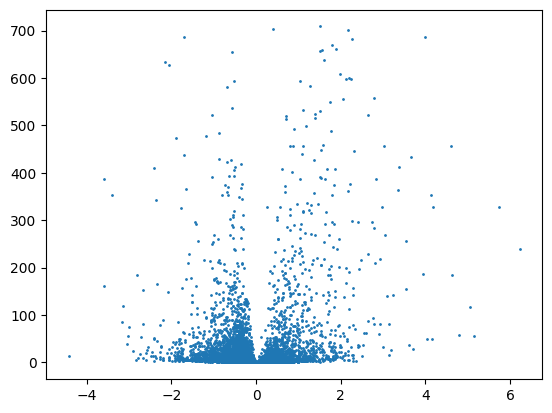

In [32]:
# fill zero p-value to 1e-800
gene_p_rpr[gene_p_rpr == 0] = 1e-800

# create volcano plot
fig, ax = plt.subplots()

ax.scatter(x=gene_beta_rpr, y=-np.log(gene_p_rpr), s=1)